# Data Parameters
Input

- Frames: 5 in 1 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V
- Temporal data (Months, Weekdays, Days, Hours)

Model
- See "Architecture"

Result
- 16.69% from baseline of 16.8% (goal below 15.41%)

In [1]:
# file locations
# for libs.plotting
import sys
sys.path.append("/home/mgraca/Workspace/hrrr-smoke-viz")
# for the model checkpoint callback (if enabled)
model_checkpoint_file = '/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/experiment_output/basic_experiments/model.keras'
# where the training data is stored
data_path = "/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [3]:
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [5]:
X_train_2 = np.load(f"{data_path + "Temporal_Encoding_X_train.npy"}")
X_test_2 = np.load(f"{data_path + "Temporal_Encoding_X_test.npy"}")
X_valid_2 = np.load(f"{data_path + "Temporal_Encoding_X_valid.npy"}")

In [6]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 
    'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Crestline - Lake Gregory', 
    'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = ['Long Beach Signal Hill']

Y_train = Y_train[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_test = Y_test[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_valid = Y_valid[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()

# Model Definition

## Architecture

In [7]:
output_frames, output_stations = Y_train.shape[1:]
input_shape_1 = X_train.shape[1:] # (frames, height, width, channels)
input_shape_2 = X_train_2.shape[1:] # (frames, encoded time)

print(
    "Frame data input\n"
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape_1}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

print(
    "Temporal data input\n"
    f"X_train shape: {X_train_2.shape}\n"
    
    f"X_test shape:  {X_test_2.shape}\n"

    f"X_valid shape: {X_valid_2.shape}\n"

    f"Input shape:   {input_shape_2}\n"
)

Frame data input
X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 1, 1)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 1, 1)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 1, 1)

Input shape:   (5, 40, 40, 3)
Output shape:  (1, 1)

Temporal data input
X_train shape: (12274, 5, 74)
X_test shape:  (2631, 5, 74)
X_valid shape: (2630, 5, 74)
Input shape:   (5, 74)



In [8]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Flatten 
from keras.layers import Input

tf.keras.backend.set_image_data_format('channels_last')

spatiotemporal_input = Input(shape=input_shape_1)
temporal_encoding_input = Input(shape=input_shape_2)
temporal_block = Flatten()(temporal_encoding_input)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding='same', return_sequences=True)(spatiotemporal_input)
x = ConvLSTM2D(filters=30, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = Conv3D(filters=15, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
conv_block = Flatten()(x)

x = Concatenate()([conv_block, temporal_block])
x = Dense(units=output_stations * output_frames, activation='relu')(x)
next_frame_pred = Reshape((output_frames, output_stations))(x)

model = Model(
    inputs=[spatiotemporal_input, temporal_encoding_input],
    outputs=next_frame_pred
)
model.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
model.summary()

2025-07-22 19:14:41.799607: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 19:14:41.809884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753236881.822588   52223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753236881.826852   52223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 19:14:41.841970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 40, 40, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 40, 40, │      9,780 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 40, 40, │     48,720 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 40, 40, │     12,165 │ conv_lstm2d_1[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 40, 40, │        406 │ conv3d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 74)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8000)      │          0 │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 370)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8370)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      8,371 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,442 (310.32 KB)

 Trainable params: 79,442 (310.32 KB)

 Non-trainable params: 0 (0.00 B)

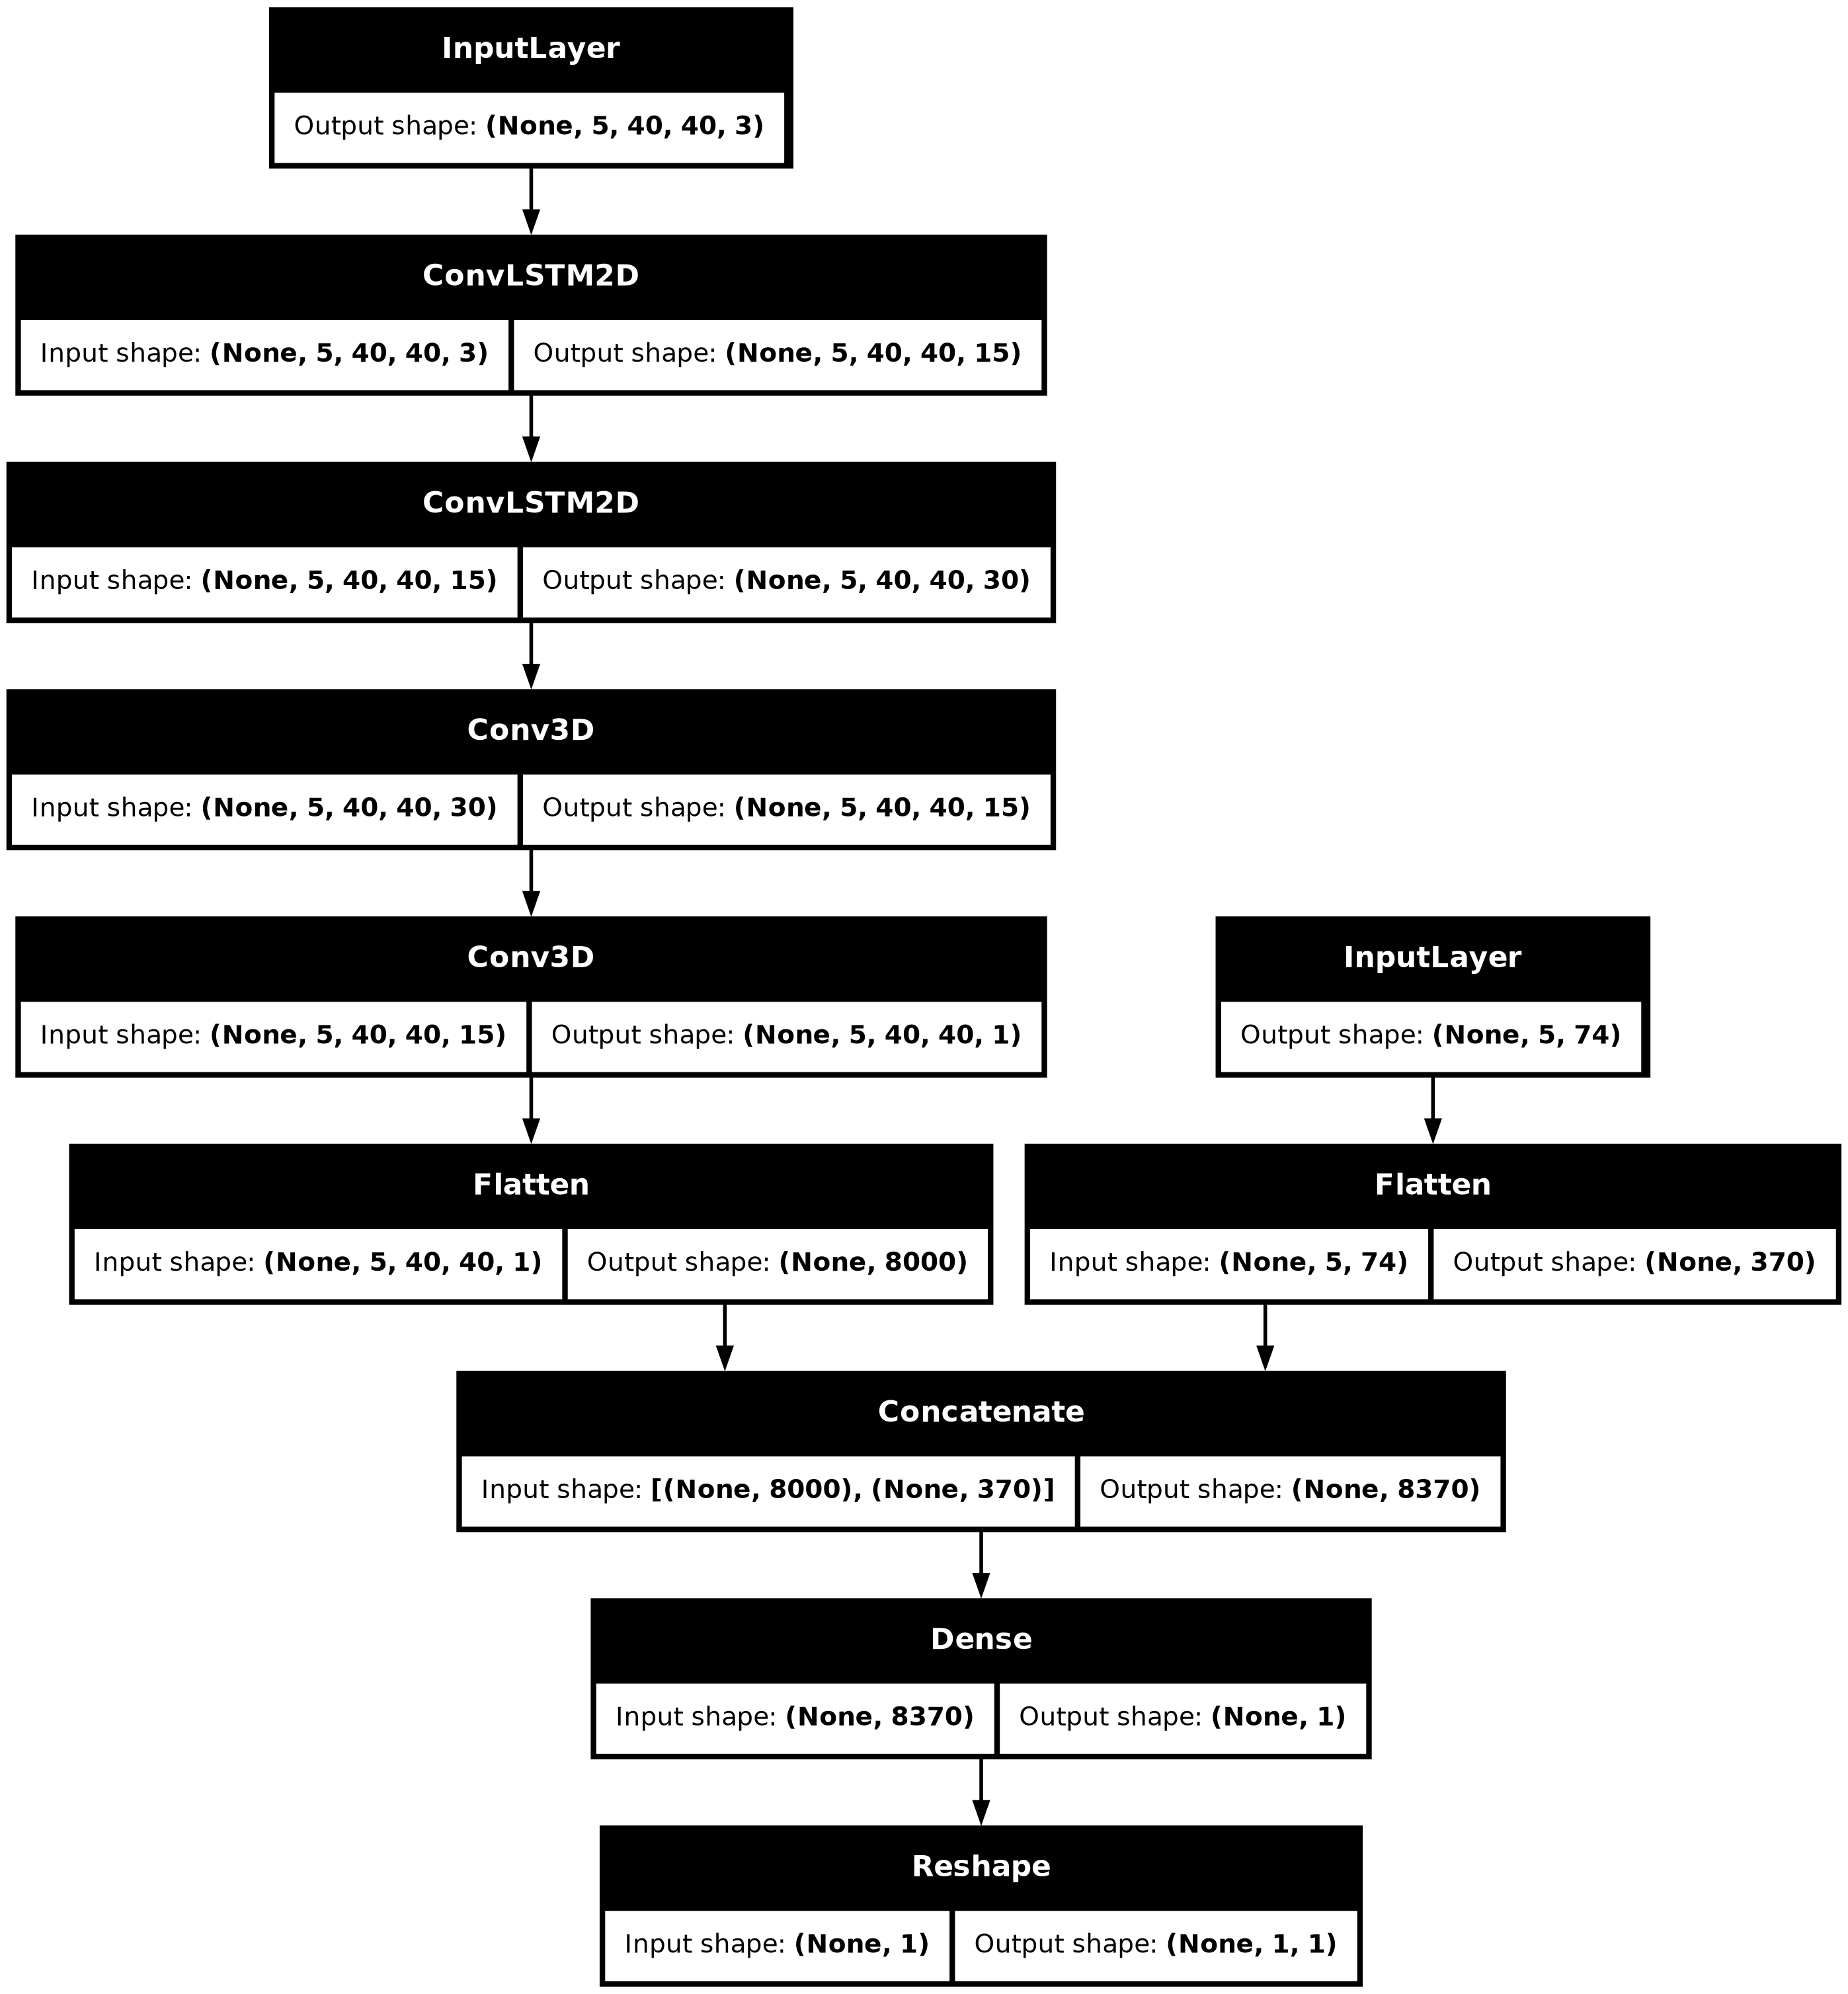

In [9]:
keras.utils.plot_model(model, "model_graph.png", show_shapes=True)

## Callbacks

In [10]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    #early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [11]:
history = model.fit(
    x=[X_train, X_train_2],
    y=Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([X_valid, X_valid_2], Y_valid),
    callbacks=callbacks
)

Epoch 1/100


/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1753236889.505004   52295 service.cc:148] XLA service 0x6007bff45380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753236889.505034   52295 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-22 19:14:49.576219: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753236889.910643   52295 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-22 19:14:50.506477: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2

  3/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 10.4231

I0000 00:00:1753236892.978594   52295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 6.1733

2025-07-22 19:15:16.732390: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-22 19:15:16.880504: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 6.1691

2025-07-22 19:15:21.922302: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-22 19:15:21.974714: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - loss: 6.1649 - val_loss: 3.7138
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 3.2777 - val_loss: 3.0450
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - loss: 3.0658 - val_loss: 3.1123
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.8347 - val_loss: 3.0396
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.7771 - val_loss: 2.8848
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.6906 - val_loss: 2.7242
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.5574 - val_loss: 2.9560
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 2.4283 - val_loss: 2.9880
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 2.3095 - val_loss: 2.6351
Epoch 10/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 2.2878 - val_loss: 2.8758
Epoch 11/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 2.1991 - val_loss: 2.8116
Epoch 12/100
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-07-22 19:55:21.933493: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-22 19:55:21.981838: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

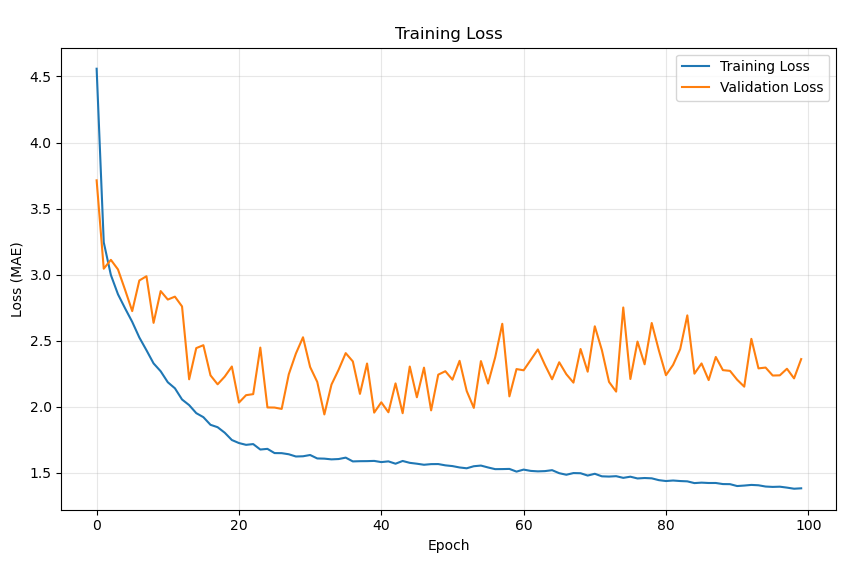

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = model.predict([X_test, X_test_2], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.322240,1.739430
NRMSE,16.802139,16.688645,12.497067
MAE,1.462357,1.553654,1.143015
R2,0.867632,0.869541,0.926773


In [14]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.322240,1.739430
NRMSE,16.802139,16.688645,12.497067
MAE,1.462357,1.553654,1.143015
R2,0.867632,0.869541,0.926773


In [15]:
# clean up dead sensors; more accurate, also allows us to use mape
from sklearn.metrics import mean_absolute_percentage_error as mape
#mape_err = mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))

dead_sens = np.where(Y_test == 0)
print(f"{len(dead_sens[0])} samples containing dead sensors removed")

cleaned_test = np.delete(Y_test, dead_sens, 0)
cleaned_pred = np.delete(y_pred, dead_sens, 0)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_test[1:]))*100,
        mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))*100,
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_pred[1:]))*100,
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

15 samples containing dead sensors removed


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.059091,1.523596
NRMSE,14.283395,14.711167,10.882469
MAE,1.414116,1.492925,1.099760
MAPE,10.834828,11.774204,9.014330
R2,0.901122,0.895217,0.942603


In [16]:
# first frame results
results = [
    [
        rmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]), 
        rmse(cleaned_pred[:, 0], cleaned_test[:, 0]),
        rmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        nrmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        nrmse(cleaned_pred[:, 0], cleaned_test[:, 0]),        
        nrmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),

    ],
    [        
        mae(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        mae(cleaned_pred[:, 0], cleaned_test[:, 0]),
        mae(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_test[1:, 0]))*100,
        mape(np.squeeze(cleaned_test[:, 0]), np.squeeze(cleaned_pred[:, 0]))*100,
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_pred[1:, 0]))*100,
    ],
    [
        r2_score(cleaned_test[:-1, 0], cleaned_test[1:, 0]),
        r2_score(cleaned_test[:, 0], cleaned_pred[:, 0]),
        r2_score(cleaned_test[:-1, 0], cleaned_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.059091,1.523596
NRMSE,14.283395,14.711167,10.882469
MAE,1.414116,1.492925,1.099760
MAPE,10.834828,11.774204,9.014330
R2,0.901122,0.895217,0.942603


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



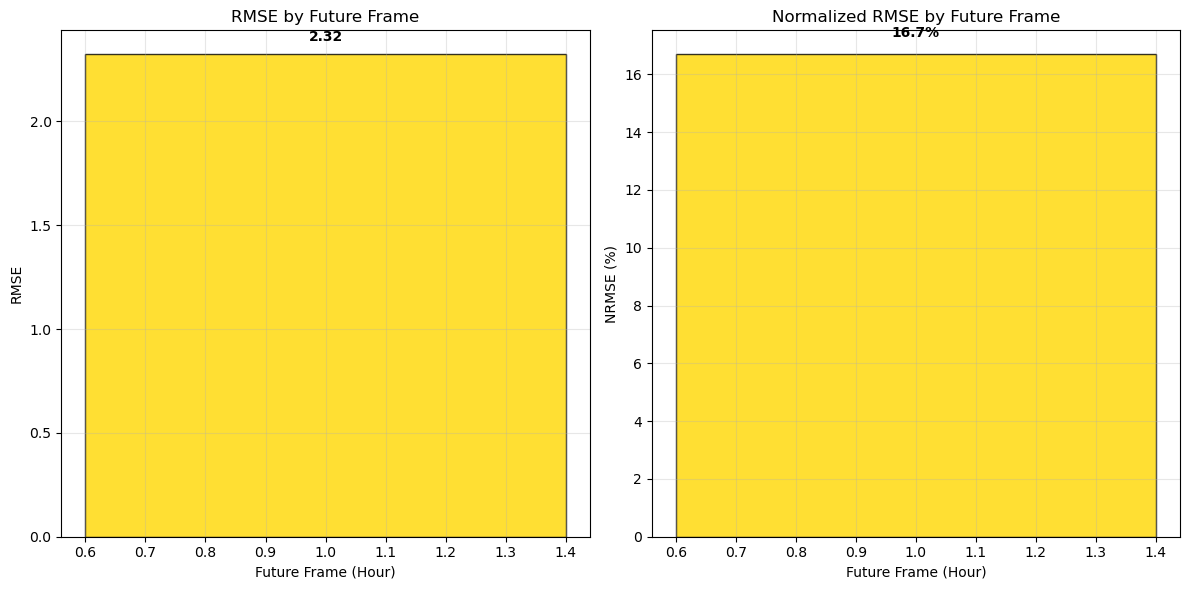


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.322 (16.7%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.322 (16.7%)   │   MAE:  1.554   │   R²:  0.870              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Long Beach Signal Hill   │2.32   │16.7  %│1.55   │0.870  │

In [17]:
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



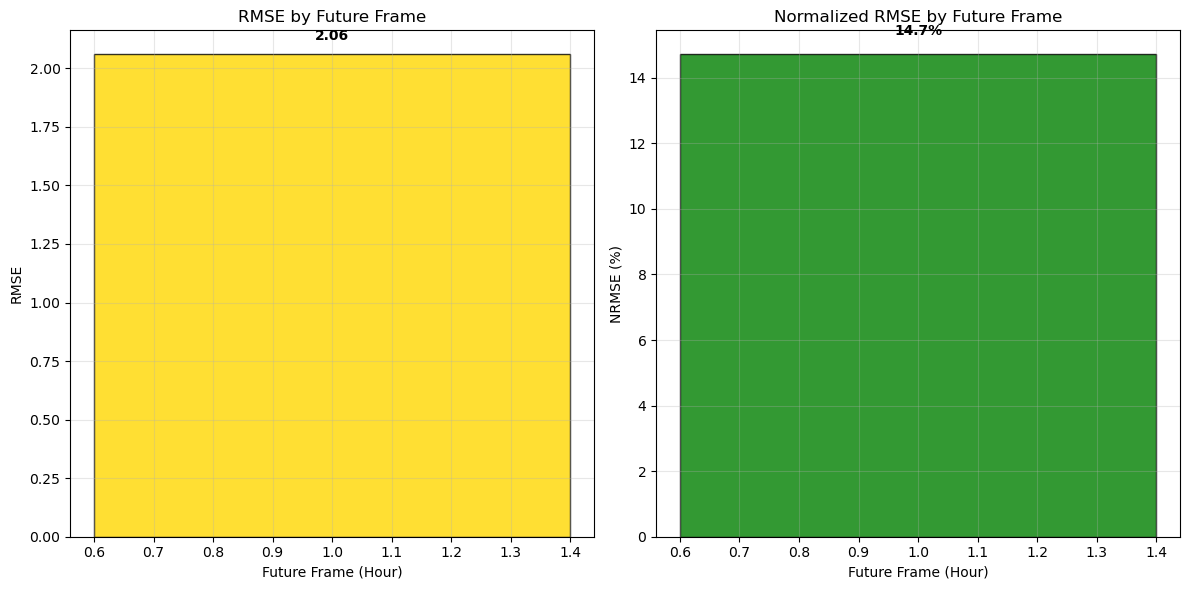


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.059 (14.7%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.059 (14.7%)   │   MAE:  1.493   │   R²:  0.895              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Long Beach Signal Hill   │2.06   │14.7  %│1.49   │0.895  │

In [18]:
plot_frame_by_frame_rmse(cleaned_pred, cleaned_test)
print_detailed_frame_stats(cleaned_pred, cleaned_test, sensor_names)

# Plots

## Snapshot plots - first frame

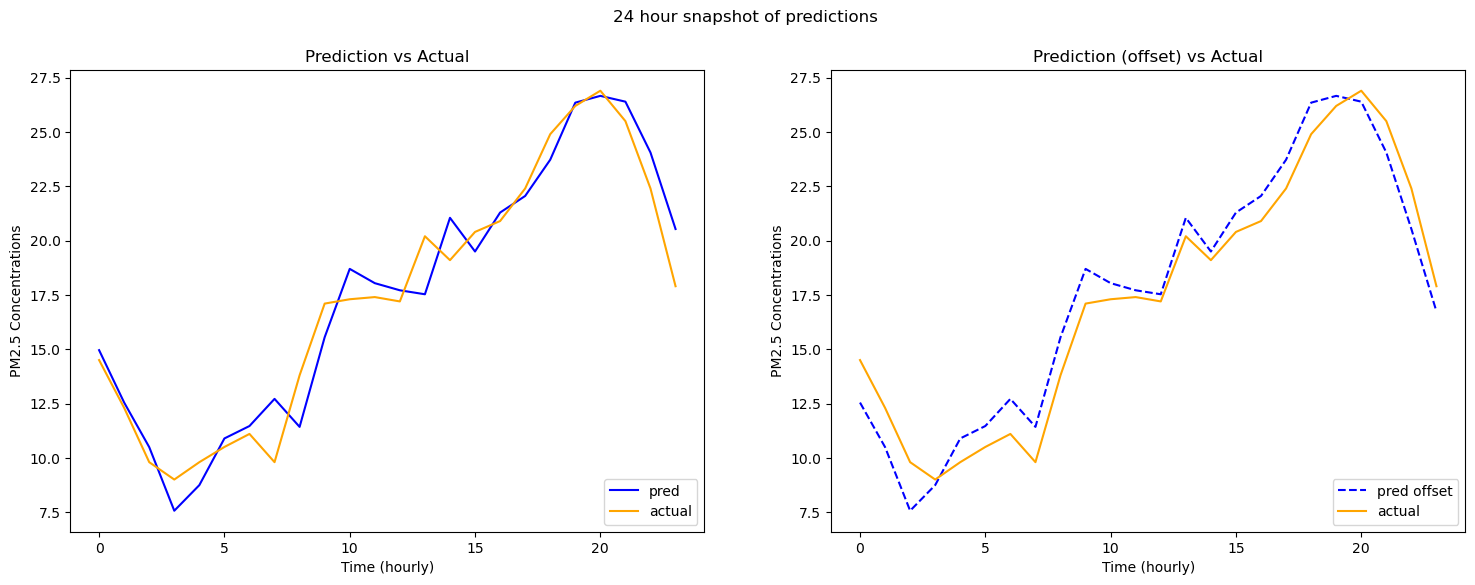

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions")

axes[0].plot(y_pred[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

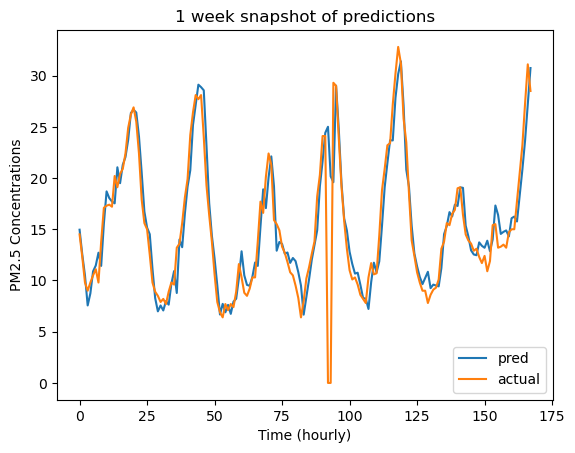

In [20]:
plt.plot(y_pred[1000:1168, 0], label='pred')
plt.plot(Y_test[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")
plt.plot()

In [21]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - 168):
    err = nrmse(y_pred[i:i+168, 0], Y_test[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

for i in range(len(cleaned_pred) - 168):
    cleaned_err = nrmse(cleaned_pred[i:i+168], cleaned_test[i:i+168])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(len(y_pred), len(cleaned_pred))

2631 2615


In [22]:
# train-valid-test
dates = pd.date_range(START_DATE, END_DATE, freq='h')[:len(Y_train) + len(Y_valid) + len(Y_test)]
print(dates.shape)
y_test_start_idx = len(Y_train) + len(Y_valid)
print(dates[y_test_start_idx:].shape) # 2631

cleaned_test_dates = np.delete(dates[y_test_start_idx:], dead_sens, 0)
cleaned_test_dates.shape

(17535,)
(2631,)


(2615,)

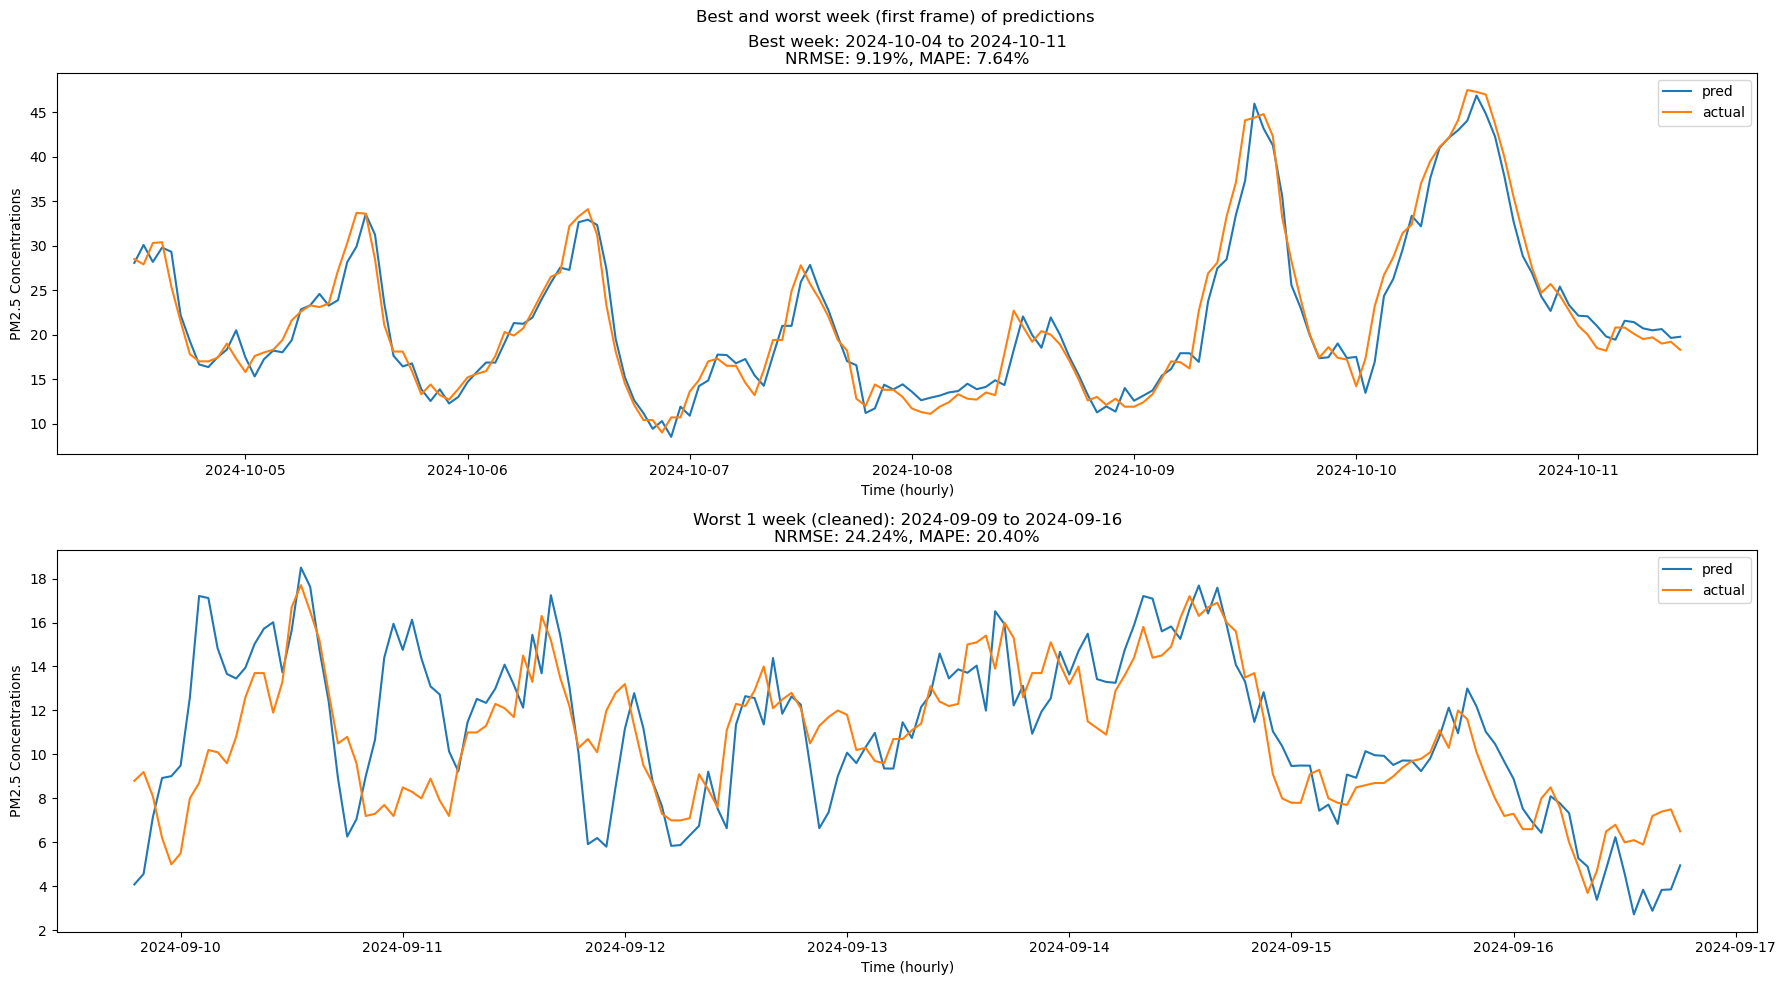

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx : best_idx + 168]), 
        np.squeeze(y_pred[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week (cleaned)
axes[1].plot(
    #dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + 168],
    cleaned_test_dates[worst_idx_cleaned : worst_idx_cleaned + 168],
    cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+168, 0], 
    label='pred'
)
axes[1].plot(
    #dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + 168],
    cleaned_test_dates[worst_idx_cleaned : worst_idx_cleaned + 168],
    cleaned_test[worst_idx_cleaned:worst_idx_cleaned+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week (cleaned): {cleaned_test_dates[worst_idx_cleaned].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_cleaned + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week_cleaned:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_cleaned : worst_idx_cleaned + 168]), 
        np.squeeze(y_pred[worst_idx_cleaned : worst_idx_cleaned + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots

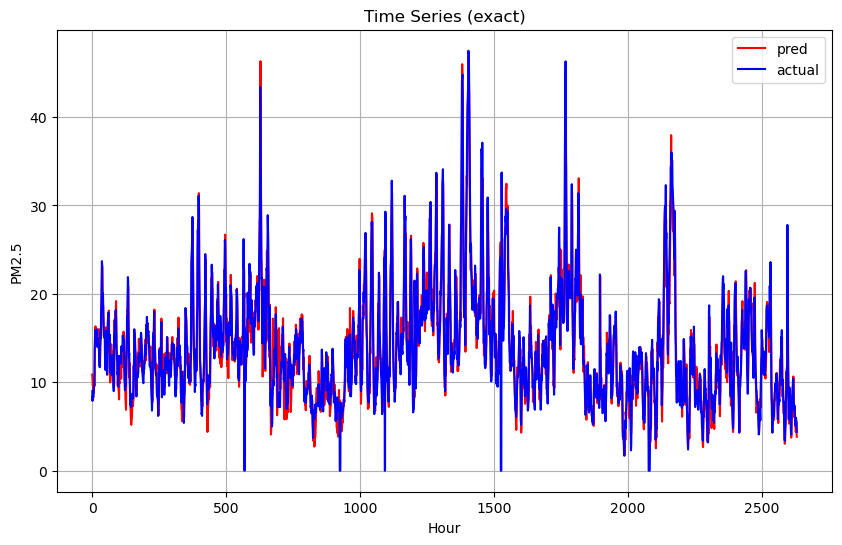

In [24]:
series_pred = pd.Series(np.squeeze(y_pred[:, 0]))
series_test = pd.Series(np.squeeze(Y_test[:, 0]))

plt.figure(figsize=(10, 6))
plt.plot(series_pred, label=f'pred', color='red')
plt.plot(series_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

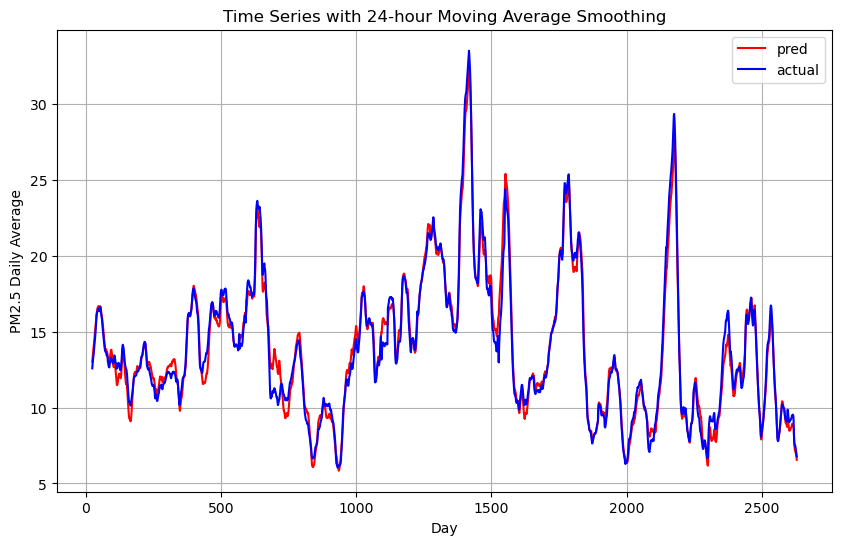

In [25]:
import pandas as pd

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

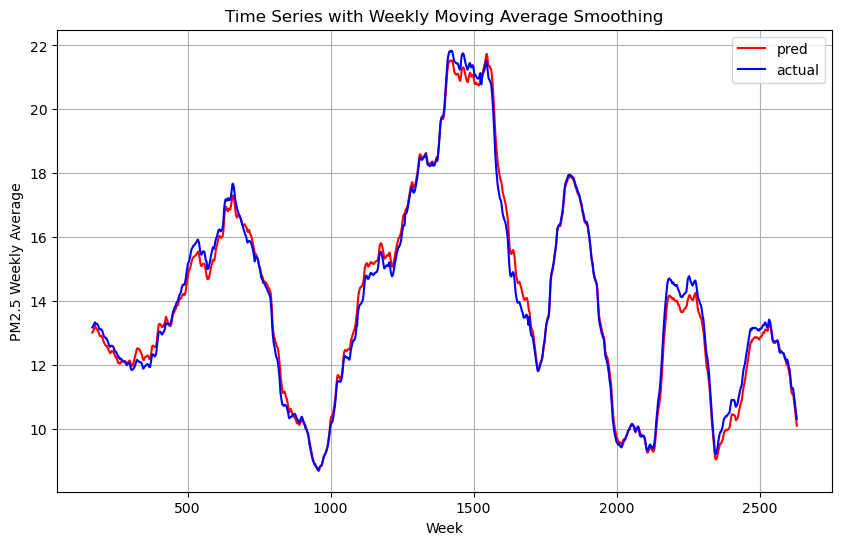

In [26]:
window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

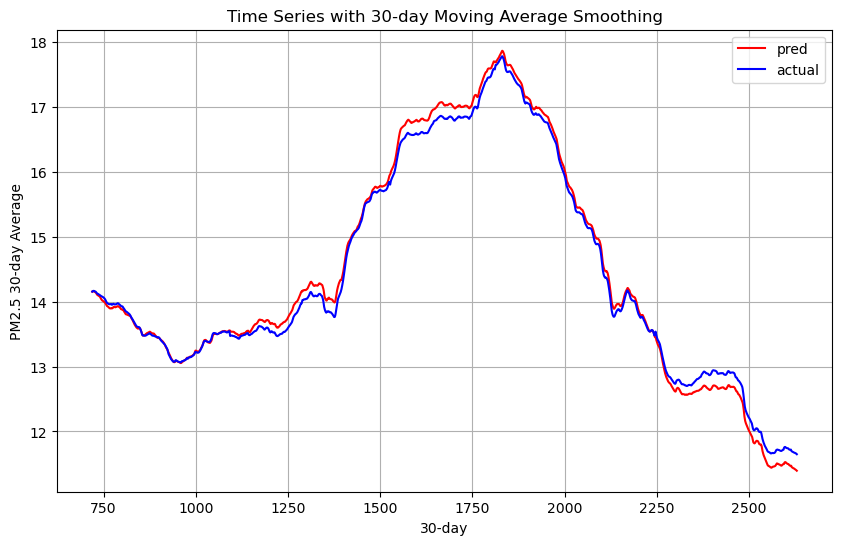

In [27]:
window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

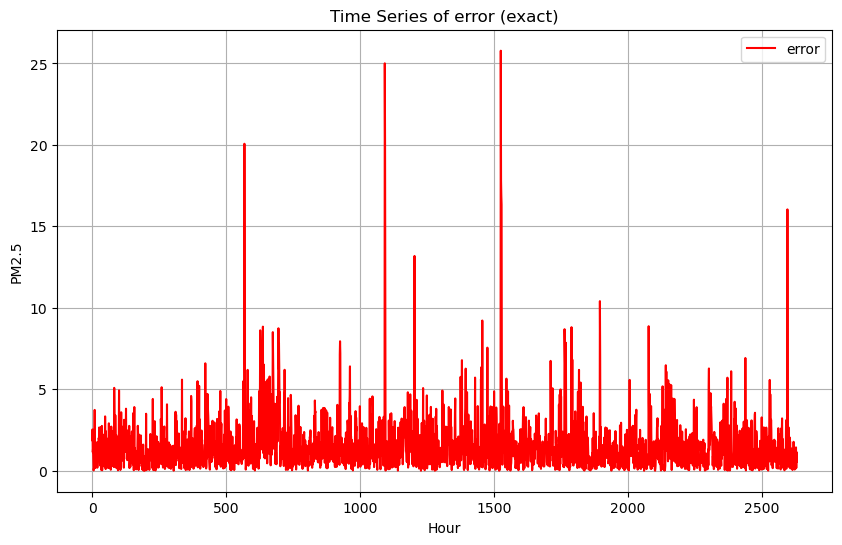

In [28]:
series = pd.Series(np.squeeze(np.abs(y_pred[:, 0] - Y_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

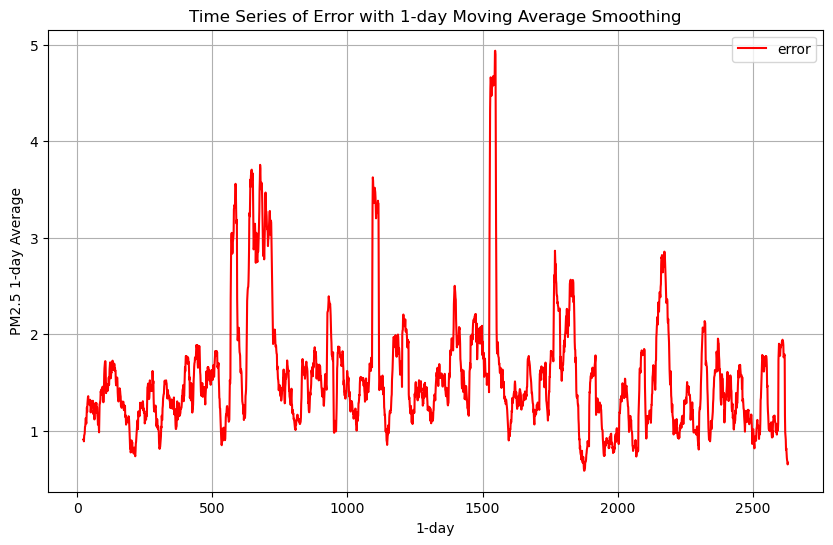

In [29]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

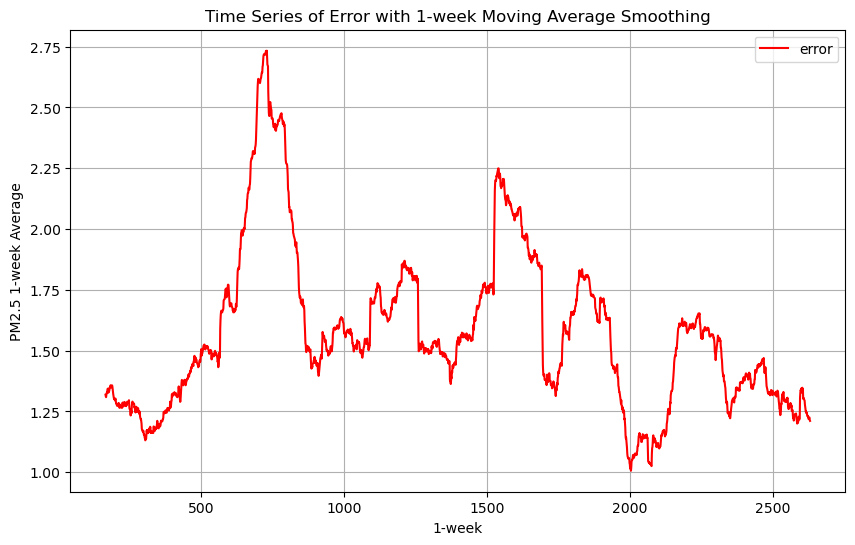

In [30]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

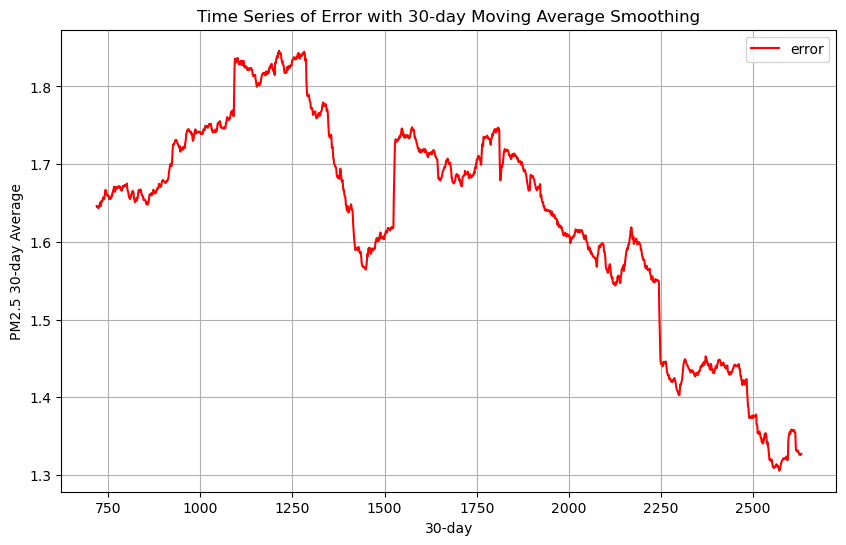

In [31]:
window_size = 720 # 30-day average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

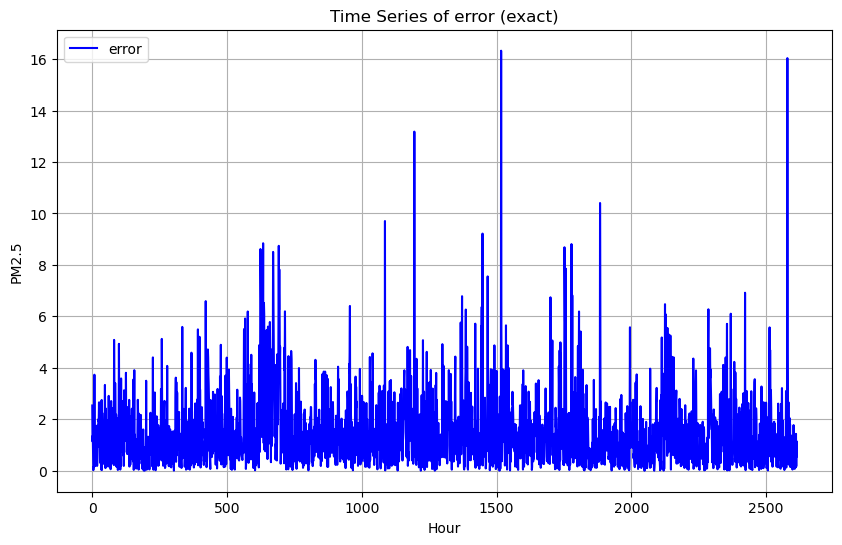

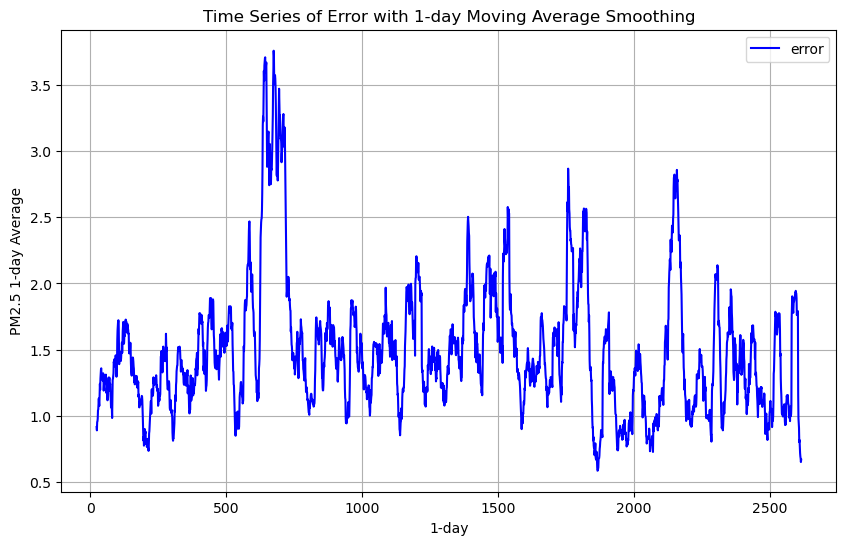

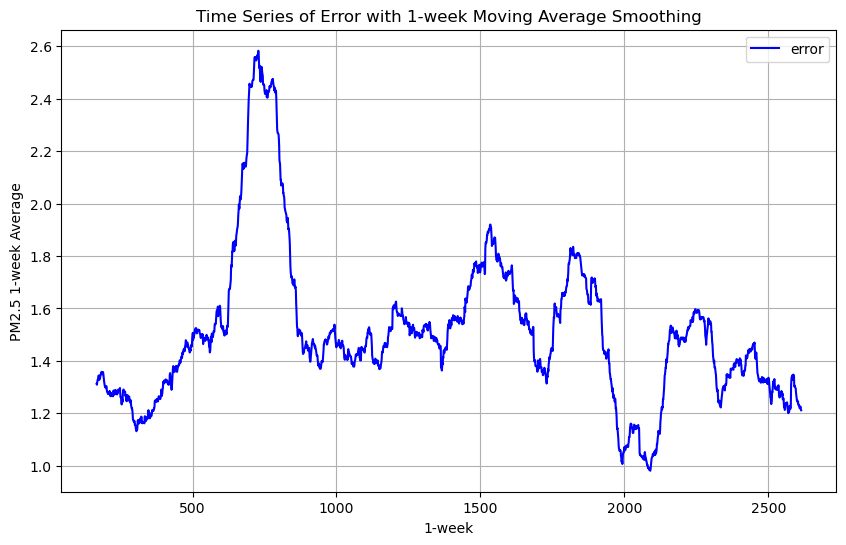

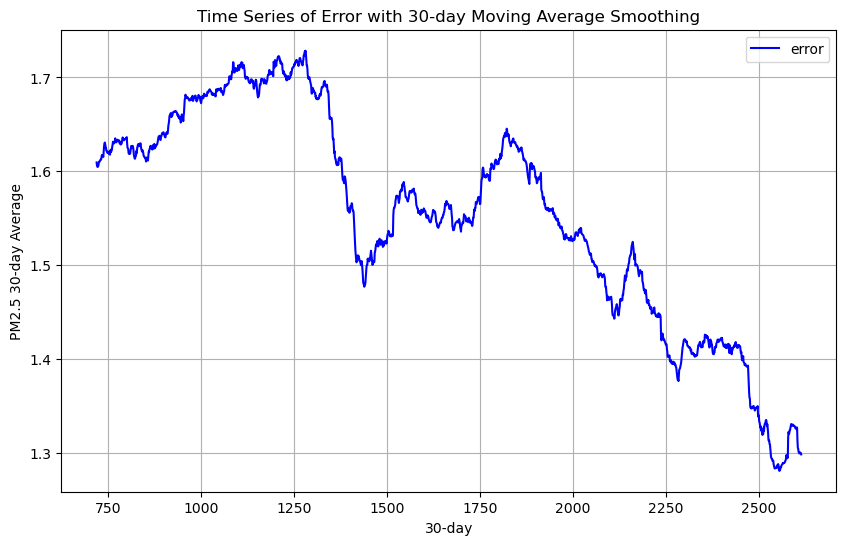

In [32]:
# cleaned plots
cleaned_series = pd.Series(np.squeeze(np.abs(cleaned_pred[:, 0] - cleaned_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(cleaned_series, label=f'error', color='blue')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

window_size = 24 # daily average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

window_size = 168 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

window_size = 720 # 30-day average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()